###  АБ - теста нового алгоритма выдачи на пользователях из 1 и 2 группы с 2023-01-31 по 2023-02-06

❌❌❌ **Результаты:** </br>
АБ-тест проводился на группах 1 (контрольная) и 2 (тестовая) в период с '2023-01-31' по '2023-02-06'</br>
Новый алгоритм выдачи оказал статистически значимое **НЕГАТИВНОЕ** воздействие на CRT. </br>
Раскатывать алгоритм на всех пользователей для повышения CTR **НЕ РЕКОМЕНДУЕТСЯ.** </br>

**Подробнее в ноутбуке ниже.**

### Потенциально, что могло повлиять на результат: 

1) Не удалось изолировать тестовую группу от контрольной. Возможно, выполненное сплиттование (Хоть и делит пользователей на эквивалентные группы) не учитывает взаимодействие людей внутри групп. Люди так или иначе взаимодействуют между собой, делясь постами из соц.сетей и сплиттование без учета соц.графов или др. методов может "испортить" результаты тестов.
2) Новый алгоритм действительно не очень удачный. Двугорбость распределения CTR в тестовой группе и расположение "горбов"  по обе стороны относительно моды контрольной группы может быть вызвана увеличением CTR среди одной когорты пользователей, и снижением в другой. Одна из возможных причин - ML модель обучена на тестовой выборке, которая обладает низкой репрезентативностью ГС пользователей.

В иследовании используются следующие методы:
* T-test и Манна-Уитни на полученных данных
* T-test и Манна-Уитни на Пуассоновском бутстрепе
* T-test и Манна-Уитни на Сглаженном CTR (a = 5)
* T-test и Манна-Уитни после Бакетного преобразования

In [3]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Данные для подключения к БД
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230220',
                      'user':os.environ.get("DB_LOGIN"),
                      'password':os.environ.get("DB_PASS")
             }

In [5]:
# Для проведения АБ теста выгружаю из clickhouse пользователей из 1 и 2 группы с 2023-01-31 по 2023-02-06.

query = '''
SELECT user_id, exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-31' and '2023-02-06' 
AND exp_group in (1, 2)
GROUP BY user_id, exp_group
'''

df = ph.read_clickhouse(query, connection=connection)

## T-test и Манна-Уитни на полученных данных

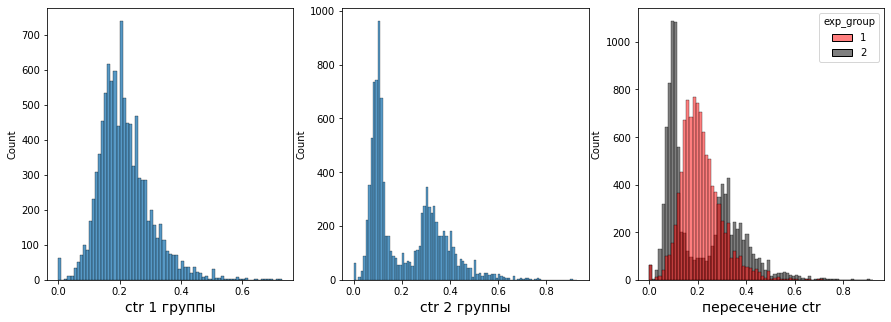

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.histplot(df[df.exp_group == 1], x='ctr', binwidth= 0.01)
plt.xlabel('ctr 1 группы', fontsize=14)

plt.subplot(1,3,2)
sns.histplot(df[df.exp_group == 2], x='ctr', binwidth= 0.01)
plt.xlabel('ctr 2 группы', fontsize=14)

plt.subplot(1,3,3)
sns.histplot(df, x='ctr', hue='exp_group', palette=['red','black'])
plt.xlabel('пересечение ctr', fontsize=14);

* Распределение ctr 1 группы: унимодальное, симметричное
* Распределение сtr 2 группы: не унимодальное, ассиметричное

In [77]:
# Убедимся, что распределение CTR внутри группы 2 не является нормальным
stats.shapiro(df[df.exp_group == 2])

ShapiroResult(statistic=0.4306674003601074, pvalue=0.0)

### Результат

In [74]:
print (f'P уровень значимости на t-тесте  \t{stats.ttest_ind(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr, equal_var=False)[1]}')
print (f'P уровень значимости Манна-Уитни \t{stats.mannwhitneyu(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr)[1]}')

P уровень значимости на t-тесте  	0.4780623130874935
P уровень значимости Манна-Уитни 	6.0376484617779035e-56


___

## T-test и Манна-Уитни на Пуассоновском бутстрепе

In [10]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64) 
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [18]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

In [44]:
global_poisson_ctr = pd.DataFrame(ctr1, columns=['group_1']).merge(pd.DataFrame(ctr2, columns=['group_2']), left_index=True, right_index=True)

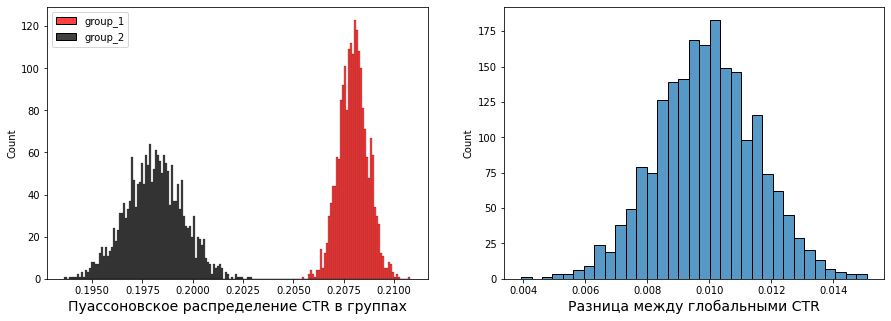

In [53]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.histplot(global_poisson_ctr, binwidth=0.0001, palette=['red','black'])
plt.xlabel('Пуассоновское распределение CTR в группах', fontsize=14);

plt.subplot(1,2,2)
sns.histplot(ctr1 - ctr2);
plt.xlabel('Разница между глобальными CTR', fontsize=14);

Важно заметить, что показатели в контрольной группе - выше

### Результат

In [50]:
print (f'P уровень значимости на t-тесте  \t {stats.ttest_ind(global_poisson_ctr.group_1, global_poisson_ctr.group_2, equal_var=False)[1]}')
print (f'P уровень значимости Манна-Уитни \t {stats.mannwhitneyu(global_poisson_ctr.group_1, global_poisson_ctr.group_2)[1]}')

P уровень значимости на t-тесте  	 0.0
P уровень значимости Манна-Уитни 	 0.0


____

## T-test и Манна-Уитни на Сглаженном CTR (a = 5)

In [51]:
# Сглаживающая функция

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

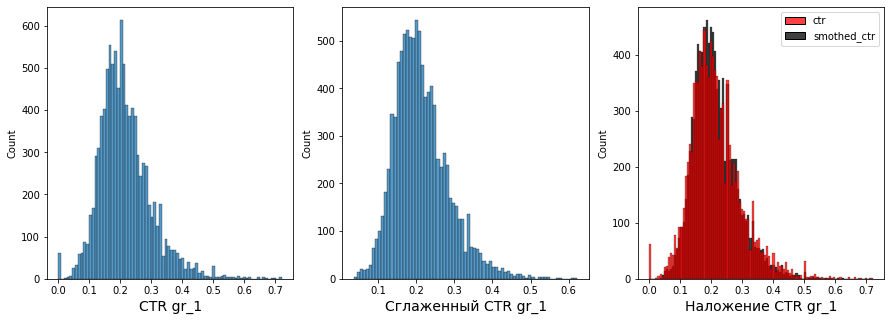

In [56]:
# Сглаживание CTR группы 1

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
group1 = df[df.exp_group == 1].copy()
sns.histplot(group1.ctr);
plt.xlabel('CTR gr_1',fontsize=14)

plt.subplot(1,3,2)
group1['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
sns.histplot(group1.smothed_ctr);
plt.xlabel('Сглаженный CTR gr_1', fontsize=14)

plt.subplot(1,3,3)
sns.histplot(group1[['ctr','smothed_ctr']], palette=['red','black'])
plt.xlabel('Наложение CTR gr_1', fontsize=14);

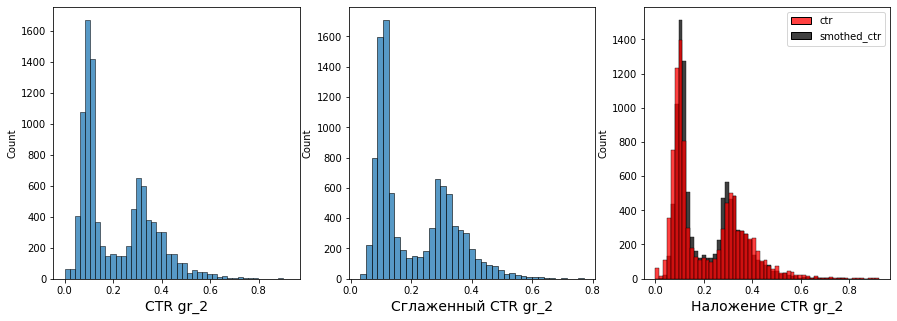

In [57]:
# Сглаживание CTR группы 2

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
group2 = df[df.exp_group == 2].copy()
sns.histplot(group2.ctr);
plt.xlabel('CTR gr_2',fontsize=14)

plt.subplot(1,3,2)
group2['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
sns.histplot(group2.smothed_ctr);
plt.xlabel('Сглаженный CTR gr_2', fontsize=14)

plt.subplot(1,3,3)
sns.histplot(group2[['ctr','smothed_ctr']], palette=['red','black'])
plt.xlabel('Наложение CTR gr_2', fontsize=14);

### Результат

In [66]:
print (f'P уровень значимости на t-тесте  \t{stats.ttest_ind(group1.smothed_ctr, group2.smothed_ctr, equal_var=False)[1]}')
print (f'P уровень значимости Манна-Уитни \t{stats.mannwhitneyu(group1.smothed_ctr, group2.smothed_ctr)[1]}')

P уровень значимости на t-тесте  	0.0223769815558559
P уровень значимости Манна-Уитни 	1.6163964114270227e-61


____

## Бакетное преобразование

In [68]:
# Выполняем бакетное преобразование данных
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%100 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-01-31' and '2023-02-06'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = ph.read_clickhouse(q, connection=connection)

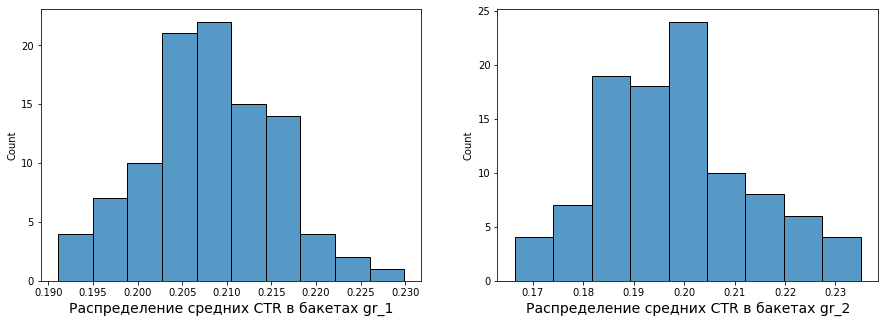

In [69]:
bucket_ctr_gr1 = df_bucket[df_bucket.exp_group == 1].bucket_ctr
bucket_ctr_gr2 = df_bucket[df_bucket.exp_group == 2].bucket_ctr

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(bucket_ctr_gr1)
plt.xlabel('Распределение средних CTR в бакетах gr_1', fontsize=14);
plt.subplot(1,2,2)
sns.histplot(bucket_ctr_gr2);
plt.xlabel('Распределение средних CTR в бакетах gr_2', fontsize=14);

### Результат

In [73]:
stats.ttest_ind(bucket_ctr_gr1, bucket_ctr_gr2)
stats.mannwhitneyu(bucket_ctr_gr1, bucket_ctr_gr2)

print (f'P уровень значимости на t-тесте  \t{stats.ttest_ind(bucket_ctr_gr1, bucket_ctr_gr2)[1]}')
print (f'P уровень значимости Манна-Уитни \t{stats.mannwhitneyu(bucket_ctr_gr1, bucket_ctr_gr2)[1]}')

P уровень значимости на t-тесте  	6.514146015763768e-09
P уровень значимости Манна-Уитни 	4.287922761364236e-09


### Результаты тестов: 

_**CTR**_:  </br>
T-test P_value: ~0.478 </br>
MannWhitney P_value: ~6.038(e-56) </br>

_**CTR сглаженный**_: </br>
T-test P_value  	~0.0224 </br>
MannWhitney P_value 	~1.616(e-61)  </br>                                                   

_**Пуассоновский бутстреп**_: </br>
T-test P_value 	 0.0 </br>
MannWhitney P_value 	 0.0 </br>

_**Бакетное преобразование**_: </br> 
T-test P_value  	~6.514(e-09) </br>
MannWhitney P_value 	~4.287(e-09) </br>

### Вывод 
Среди всех проведенных тестов, только T-Test на CTR не показал значимых отличий между группами. Однако, он проводился вопреки условию о нормальности распределений в группах. (Подтверждено тестом Шапиро на нормальность).
Сглаживание CTR дало нам основания отклонить нулевую гипотезу.

Тест Манна-Уитни во всех случаях показал, 
что зона перекрещивающихся значения выборок достаточно мала, что дает нам основания полагать, что CTR экспериментальных групп отличаются. Причем значение в тестовой группе- выше.

Самые наглядные результаты дало Пуассоновское преобразование данных. Распределения даже не пересеклись на графике.

Новый алгоритм выдачи оказал статистически значимое **НЕГАТИВНОЕ** воздействие на CRT. </br>
Раскатывать алгоритм на всех пользователей для повышения CTR **НЕ РЕКОМЕНДУЕТСЯ.**